In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [4]:
# Assume CSV files are already imported into dataframes
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')


In [5]:
def clean_data(df):
    print(f"\nPreview of {df.name}:")
    print(df.head())
    print("\nInfo:")
    print(df.info())
    print("\nMissing values:")
    print(df.isnull().sum())

In [6]:
customers_df.name, products_df.name, transactions_df.name = 'Customers', 'Products', 'Transactions'
clean_data(customers_df)
clean_data(products_df)
clean_data(transactions_df)


Preview of Customers:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Missing values:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Preview of Products:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear 

In [7]:
def plot_bar(data, x, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=x, palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()

<ipython-input-7-237749052a3f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x, palette='viridis')


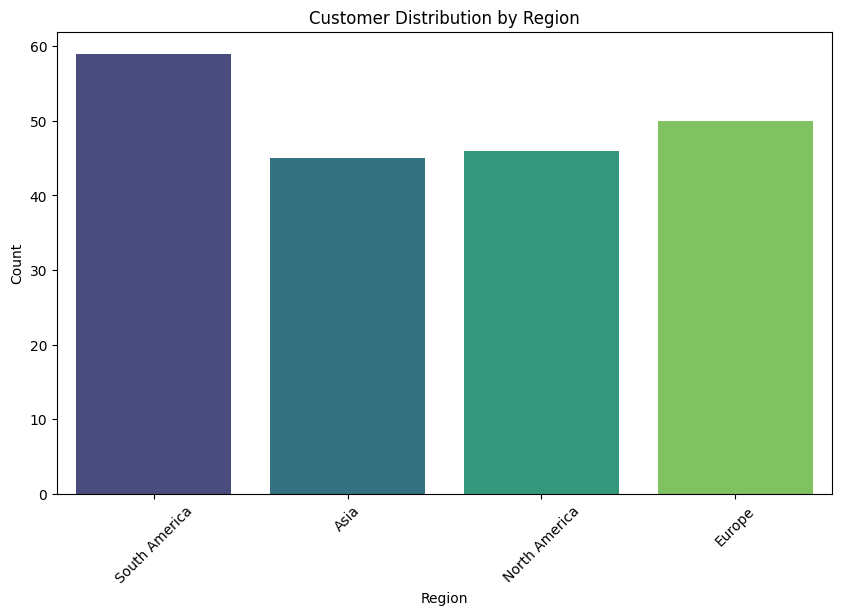

<ipython-input-7-237749052a3f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x=x, palette='viridis')


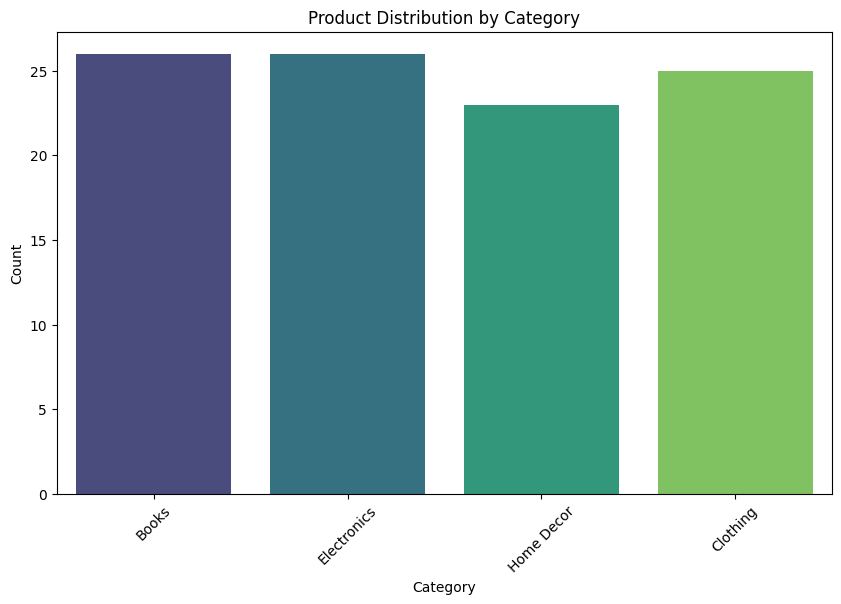

In [8]:
plot_bar(customers_df, 'Region', 'Customer Distribution by Region', 'Region', 'Count')
plot_bar(products_df, 'Category', 'Product Distribution by Category', 'Category', 'Count')

In [9]:
popular_categories = transactions_df.merge(products_df, on='ProductID')
popular_categories = popular_categories.groupby('Category')['Quantity'].sum().sort_values(ascending=False)
print("\nPopular product categories:\n", popular_categories)


Popular product categories:
 Category
Books          681
Home Decor     639
Electronics    627
Clothing       590
Name: Quantity, dtype: int64


In [10]:
highest_transaction = transactions_df.nlargest(5, 'TotalValue')
print("\nTop 5 transactions with the highest value:\n", highest_transaction)



Top 5 transactions with the highest value:
     TransactionID CustomerID ProductID      TransactionDate  Quantity  \
879        T00928      C0082      P075  2024-09-06 18:39:07         4   
509        T00499      C0065      P032  2024-07-18 02:51:22         4   
971        T00307      C0044      P045  2024-05-30 18:15:28         4   
560        T00070      C0051      P017  2024-12-11 13:46:30         4   
562        T00224      C0171      P017  2024-07-06 23:53:24         4   

     TotalValue   Price  
879     1991.04  497.76  
509     1954.52  488.63  
971     1927.12  481.78  
560     1879.08  469.77  
562     1879.08  469.77  


In [16]:

# Task 2: Lookalike Model
# Feature Engineering
customer_transactions = transactions_df.groupby('CustomerID').agg({'Quantity': 'sum', 'TotalValue': 'sum'}).reset_index()
customer_profiles = customers_df.merge(customer_transactions, on='CustomerID', how='left').fillna(0)
scaler = StandardScaler()
customer_features = scaler.fit_transform(customer_profiles[['Quantity', 'TotalValue']])

In [12]:
similarity_matrix = cosine_similarity(customer_features)

In [13]:
lookalikes = {}
for i, customer_id in enumerate(customer_profiles['CustomerID'][:20]):
    similarity_scores = list(enumerate(similarity_matrix[i]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes[customer_id] = [(customer_profiles.iloc[idx]['CustomerID'], score) for idx, score in similarity_scores]

In [14]:
lookalikes_df = pd.DataFrame.from_dict(lookalikes, orient='index', columns=['Customer 1', 'Customer 2', 'Customer 3'])
lookalikes_df.to_csv('Lookalike.csv', index_label='CustomerID')
print("Lookalike recommendations saved as Lookalike.csv")

Lookalike recommendations saved as Lookalike.csv


In [15]:
# Task 3: Customer Segmentation
# Feature Engineering
segmentation_data = scaler.fit_transform(customer_profiles[['Quantity', 'TotalValue']])

In [17]:

# K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(segmentation_data)
customer_profiles['Cluster'] = clusters

In [18]:
# Clustering Metrics
sil_score = silhouette_score(segmentation_data, clusters)
db_index = davies_bouldin_score(segmentation_data, clusters)
print(f"\nClustering Results: Silhouette Score = {sil_score}, DB Index = {db_index}")


Clustering Results: Silhouette Score = 0.4539109087769898, DB Index = 0.7102764046737506


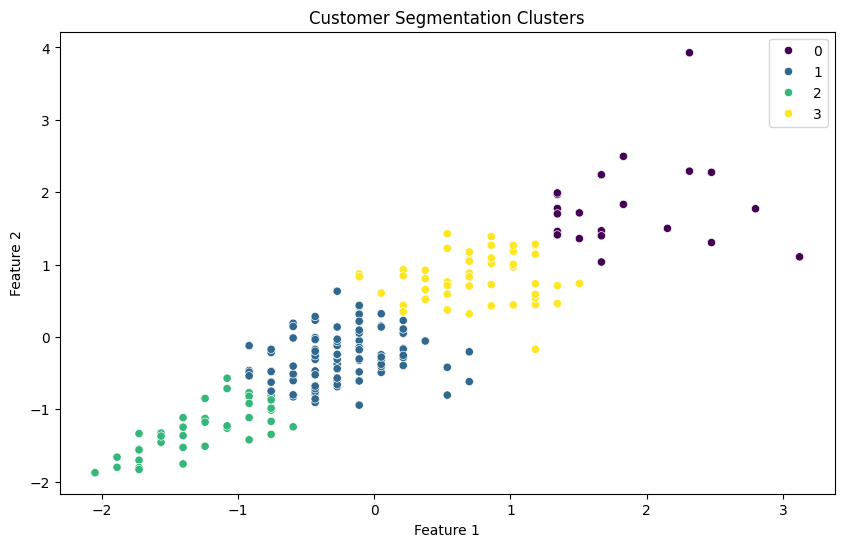

In [19]:
# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=segmentation_data[:, 0], y=segmentation_data[:, 1], hue=clusters, palette='viridis')
plt.title('Customer Segmentation Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [20]:

# Save Final Results
customer_profiles.to_csv('Customer_Clusters.csv', index=False)
print("Customer clusters saved as Customer_Clusters.csv")


Customer clusters saved as Customer_Clusters.csv
